<a href="https://www.kaggle.com/code/sonnyinkai369/ghrs-recsys?scriptVersionId=153241349" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as plt
import networkx as nx
import itertools
import collections
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data

In [2]:
train_by_user = pd.read_csv("/kaggle/input/datahotel/train_total_by_user_38k1.csv")
test_by_user  = pd.read_csv("/kaggle/input/datahotel/test_by_user_695.csv")
train_by_user

,URL Hotel,Location,HotelID,Name Hotel,Descriptions,Address,UserID,User,Rating
0,https://www.booking.com/hotel/vn/dalat-wind.vi...,Đà Lạt,4064,Dalat Wind Deluxe Hotel,"Tọa lạc tại thành phố Đà Lạt, cách Hồ Xuân Hươ...","Lot R2 03-04. Golf Valley, Ward 2, Đà Lạt, Viê...",1187,Thảo,6
1,https://www.booking.com/hotel/vn/dalat-wind.vi...,Đà Lạt,4064,Dalat Wind Deluxe Hotel,"Tọa lạc tại thành phố Đà Lạt, cách Hồ Xuân Hươ...","Lot R2 03-04. Golf Valley, Ward 2, Đà Lạt, Viê...",5866,Tho,6
2,https://www.booking.com/hotel/vn/dalat-wind.vi...,Đà Lạt,4064,Dalat Wind Deluxe Hotel,"Tọa lạc tại thành phố Đà Lạt, cách Hồ Xuân Hươ...","Lot R2 03-04. Golf Valley, Ward 2, Đà Lạt, Viê...",3033,Tuan,9
3,https://www.booking.com/hotel/vn/dalat-wind.vi...,Đà Lạt,4064,Dalat Wind Deluxe Hotel,"Tọa lạc tại thành phố Đà Lạt, cách Hồ Xuân Hươ...","Lot R2 03-04. Golf Valley, Ward 2, Đà Lạt, Viê...",1406,Phan,7
4,https://www.booking.com/hotel/vn/dalat-wind.vi...,Đà Lạt,4064,Dalat Wind Deluxe Hotel,"Tọa lạc tại thành phố Đà Lạt, cách Hồ Xuân Hươ...","Lot R2 03-04. Golf Valley, Ward 2, Đà Lạt, Viê...",841,Hong,8
...,...,...,...,...,...,...,...,...,...
38061,https://www.booking.com/hotel/vn/littleboss.vi...,Huế,135,LittleBoss,Căn hộ có TV màn hình phẳng. Căn hộ nằm trong...,"The Manor Crown Đường Tố Hữu, TP Huêa, Huế, Vi...",2190,Linh,6
38062,https://www.booking.com/hotel/vn/littleboss.vi...,Huế,135,LittleBoss,Căn hộ có TV màn hình phẳng. Căn hộ nằm trong...,"The Manor Crown Đường Tố Hữu, TP Huêa, Huế, Vi...",1530,Anh,9
38063,https://www.booking.com/hotel/vn/littleboss.vi...,Huế,135,LittleBoss,Căn hộ có TV màn hình phẳng. Căn hộ nằm trong...,"The Manor Crown Đường Tố Hữu, TP Huêa, Huế, Vi...",1308,Phong,7
38064,https://www.booking.com/hotel/vn/littleboss.vi...,Huế,135,LittleBoss,Căn hộ có TV màn hình phẳng. Căn hộ nằm trong...,"The Manor Crown Đường Tố Hữu, TP Huêa, Huế, Vi...",6009,Hạnh,6


Tạo tập train test, chỉ dụng các cột và đổi tên tương ứng


In [3]:
train = train_by_user.loc[:, ['UserID', 'HotelID', 'Rating']]
train = train.rename(columns={'UserID': 'UID', 'HotelID': 'MID', 'Rating': 'rate'})
train

,UID,MID,rate
0,1187,4064,6
1,5866,4064,6
2,3033,4064,9
3,1406,4064,7
4,841,4064,8
...,...,...,...
38061,2190,135,6
38062,1530,135,9
38063,1308,135,7
38064,6009,135,6


In [4]:
test = test_by_user.loc[:, ['UserID', 'HotelID', 'Rating']]
test = test.rename(columns={'UserID': 'UID', 'HotelID': 'MID', 'Rating': 'rate'})

In [5]:
df_user = pd.DataFrame(range(1, 6472), columns=['UID'])
df_user

,UID
0,1
1,2
2,3
3,4
4,5
...,...
6466,6467
6467,6468
6468,6469
6469,6470


# Tạo ra thông tin của user thông qua khu vực mà họ ghé qua nhiều nhất (Phần làm thêm, chưa làm kịp trong đồ án này, chạy file pretrain sẵn ở dưới)

In [6]:
train_by_user[train_by_user['UserID'] == 5564].groupby(by=['Location']).count()['UserID'].idxmax()


'Đà Lạt'

In [7]:
dest_name = {'Đà Lạt': 1, 'Hà Nội': 2, 'TP. Hồ Chí Minh': 3, 'Vũng Tàu': 4, 'Đà Nẵng': 5, 'Phú Quốc': 6, 'Hội An': 7, 'Nha Trang': 8, 'Sa Pa': 9, 'Huế': 10}

In [ ]:
location_list = []
for i in range(1, df_user.shape[0] + 1): 
    location = train_by_user[train_by_user['UserID'] == i].groupby(by=['Location']).count()['UserID'].idxmax()
    location_list.append(dest_name[location])
       
df_user.loc[:, 'location'] = location_list
df_user

In [ ]:
df_user = convert_categorical(df_user, 'location')

In [ ]:
df_user

# Nếu có thông tin bên lề như quê quán nghề nghiệp user thì chạy hàm bên dưới, trong code này chỉ sử dụng Rating giữa user và item

In [ ]:
def convert_categorical(df_X, _X):
    values = np.array(df_X[_X])
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    df_X = df_X.drop(_X, axis = 1)
    for j in range(integer_encoded.max() + 1):
        df_X.insert(loc=j + 1, column=str(_X) + str(j + 1), value=onehot_encoded[:, j])
    return df_X

# Code này dùng để tìm ra thông tin user thông qua sự tương tác với các item, nếu train lại thì chạy code này

In [ ]:
alpha_coefs = [1, 2, 3]

for alpha_coef in alpha_coefs:
    pairs = []
    grouped = train.groupby(['MID', 'rate'])
    for key, group in grouped:
        pairs.extend(list(itertools.combinations(group['UID'], 2)))
    counter = collections.Counter(pairs)
    alpha = alpha_coef * 1  # param*i_no
    edge_list = map(list, collections.Counter(el for el in counter.elements() if counter[el] >= alpha_coef).keys())
    G = nx.Graph()

    for el in edge_list:
        G.add_edge(el[0], el[1], weight=1)
        G.add_edge(el[0], el[0], weight=1)
        G.add_edge(el[1], el[1], weight=1)

    pr = nx.pagerank(G.to_directed())
    df_user['PR'] = df_user['UID'].map(pr)
    df_user['PR'] /= float(df_user['PR'].max())
    dc = nx.degree_centrality(G)
    df_user['CD'] = df_user['UID'].map(dc)
    df_user['CD'] /= float(df_user['CD'].max())
    cc = nx.closeness_centrality(G)
    df_user['CC'] = df_user['UID'].map(cc)
    df_user['CC'] /= float(df_user['CC'].max())
    bc = nx.betweenness_centrality(G)
    df_user['CB'] = df_user['UID'].map(bc)
    df_user['CB'] /= float(df_user['CB'].max())
    lc = nx.load_centrality(G)
    df_user['LC'] = df_user['UID'].map(lc)
    df_user['LC'] /= float(df_user['LC'].max())
    nd = nx.average_neighbor_degree(G, weight='weight')
    df_user['AND'] = df_user['UID'].map(nd)
    df_user['AND'] /= float(df_user['AND'].max())
    X_train = df_user[df_user.columns[1:]]
    X_train.fillna(0, inplace=True)

    X_train.to_pickle("x_train_alpha("+str(alpha_coef)+").pkl")


# Đã pretrain thì chạy file này

In [6]:
import pickle 

# Open the file in binary mode 
with open('/kaggle/input/feature-dataset/x_train_alpha(1).pkl', 'rb') as file: 
    # Call load method to deserialze 
    X_train = pickle.load(file) 

X_train

,PR,CD,CC,CB,LC,AND
0,0.018572,0.003058,0.000000,0.000000,0.000000,0.003253
1,0.011670,0.013761,0.683256,0.000009,0.000008,0.513988
2,0.007053,0.004587,0.532294,0.000000,0.000000,0.035784
3,0.009149,0.007645,0.619037,0.000000,0.000000,0.134678
4,0.034185,0.027523,0.675121,0.015761,0.016473,0.207656
...,...,...,...,...,...,...
6466,0.009075,0.007645,0.622470,0.000022,0.000126,0.164606
6467,0.008782,0.009174,0.680565,0.000000,0.000000,0.551399
6468,0.008954,0.007645,0.624147,0.000000,0.000000,0.181522
6469,0.010558,0.012232,0.692734,0.000004,0.000005,0.622154


> # Tìm số lượng thành phần giữ lại khi sử dụng PCA

In [7]:
from sklearn.decomposition import PCA

# Số lượng thành phần ban đầu
num_components = X_train.shape[1]

# Khởi tạo PCA
pca = PCA(n_components=num_components)

In [8]:
# Fit và chuyển đổi dữ liệu
X_train_pca = pca.fit_transform(X_train)
X_train_pca

array([[-5.28203716e-01,  1.18166342e-01,  3.05090205e-02,
        -5.20057886e-03,  9.25269508e-03, -1.54369911e-04],
       [ 3.21406767e-01,  1.81292244e-01, -1.27075463e-02,
         2.33581626e-03, -9.43865702e-04, -5.76606924e-05],
       [-6.40820857e-02, -1.39515751e-01, -2.01253624e-02,
         2.24154455e-03, -8.22433058e-04, -3.61571109e-05],
       ...,
       [ 9.19204057e-02, -6.63629872e-02, -2.13634742e-02,
         2.53131782e-03, -6.32423004e-04, -5.28452977e-05],
       [ 3.87646922e-01,  2.67325914e-01, -1.25144844e-02,
         4.17321008e-03, -5.46142670e-04, -6.26412813e-05],
       [-2.06070061e-02, -1.21111696e-01, -1.65291066e-02,
         4.02768520e-04,  1.52594471e-03, -8.59033916e-05]])

In [9]:
# Tính tỷ lệ phương sai giữ lại cho từng thành phần
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([8.03853417e-01, 1.58354116e-01, 3.63718443e-02, 1.34441273e-03,
       7.59820980e-05, 2.28026387e-07])

In [10]:
# Tính tổng tích lũy của tỷ lệ phương sai giữ lại
cumulative_explained_variance = explained_variance_ratio.cumsum()
cumulative_explained_variance

array([0.80385342, 0.96220753, 0.99857938, 0.99992379, 0.99999977,
       1.        ])

In [11]:
# Chọn số lượng thành phần sao cho tỷ lệ phương sai giữ lại là 95%
num_components_95_percent = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components_95_percent

2

# Xây dựng model autoencoder

In [12]:
# Autoencoder for feature extraction
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

In [13]:
def autoencoder(X_train):
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    #PCA for dimensionality reduction, do số lượng ít nên để nguyên luôn
    pca = PCA(n_components=X_train.shape[1])
    X_train_pca = pca.fit_transform(X_train_scaled)


    #Autoencoder for extracting feature
    input_layer = Input(shape=(X_train_pca.shape[1],))
    encoded4 = Dense(512,activation=LeakyReLU(0.3))(input_layer)
    encoded3 = Dense(256, activation=LeakyReLU(0.3))(encoded4)
    encoded2 = Dense(128, activation=LeakyReLU(0.3))(encoded3)
    encoded1 = Dense(64, activation=LeakyReLU(0.3))(encoded2)
    encoded0 = Dense(32, activation=LeakyReLU(0.3))(encoded1)
    decoded = Dense(X_train_pca.shape[1], activation='sigmoid')(encoded0)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(loss='mse', optimizer='adam')
    autoencoder.fit(X_train_pca, X_train_pca, epochs=30, batch_size=32)

    # Extract encoded features
    encoded_features = autoencoder.predict(X_train_pca)
    return encoded_features


In [14]:
encoded_features = autoencoder(X_train)
encoded_features

Epoch 1/30
203/203 [==============================] - 2s 5ms/step - loss: 0.8048
Epoch 2/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7774
Epoch 3/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7772
Epoch 4/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7757
Epoch 5/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7751
Epoch 6/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7748
Epoch 7/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7746
Epoch 8/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7744
Epoch 9/30
203/203 [==============================] - 1s 4ms/step - loss: 0.7776
Epoch 10/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7760
Epoch 11/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7760
Epoch 12/30
203/203 [==============================] - 1s 5ms/step - loss: 0.7792
Epoch 13/30
203/203 [====

array([[2.8941125e-09, 9.9999726e-01, 7.3647481e-01, 1.3369107e-07,
        2.1766642e-01, 3.9342962e-05],
       [1.0957090e-01, 3.0652389e-10, 7.4482155e-01, 9.1817021e-02,
        3.2249070e-03, 8.6620814e-05],
       [3.3758308e-05, 4.4014210e-01, 3.2990872e-06, 1.1779942e-01,
        7.2833966e-03, 2.7836626e-05],
       ...,
       [2.2387911e-04, 2.9506598e-04, 1.4117721e-04, 1.2473711e-01,
        2.1596036e-03, 1.3467785e-05],
       [1.6223530e-01, 4.1804071e-11, 9.8542553e-01, 1.3991563e-01,
        2.9108978e-03, 1.7260053e-04],
       [1.7390907e-04, 2.3697568e-01, 3.9981142e-06, 6.1227188e-02,
        7.6254881e-03, 2.6963799e-05]], dtype=float32)

In [15]:
encoded_features

array([[2.8941125e-09, 9.9999726e-01, 7.3647481e-01, 1.3369107e-07,
        2.1766642e-01, 3.9342962e-05],
       [1.0957090e-01, 3.0652389e-10, 7.4482155e-01, 9.1817021e-02,
        3.2249070e-03, 8.6620814e-05],
       [3.3758308e-05, 4.4014210e-01, 3.2990872e-06, 1.1779942e-01,
        7.2833966e-03, 2.7836626e-05],
       ...,
       [2.2387911e-04, 2.9506598e-04, 1.4117721e-04, 1.2473711e-01,
        2.1596036e-03, 1.3467785e-05],
       [1.6223530e-01, 4.1804071e-11, 9.8542553e-01, 1.3991563e-01,
        2.9108978e-03, 1.7260053e-04],
       [1.7390907e-04, 2.3697568e-01, 3.9981142e-06, 6.1227188e-02,
        7.6254881e-03, 2.6963799e-05]], dtype=float32)

In [16]:
encoded_features.shape

(6471, 6)

# Phân các user ra các cluser

Vẽ silhoette score tìm cluster num tốt nhất

In [17]:
from sklearn.cluster import KMeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

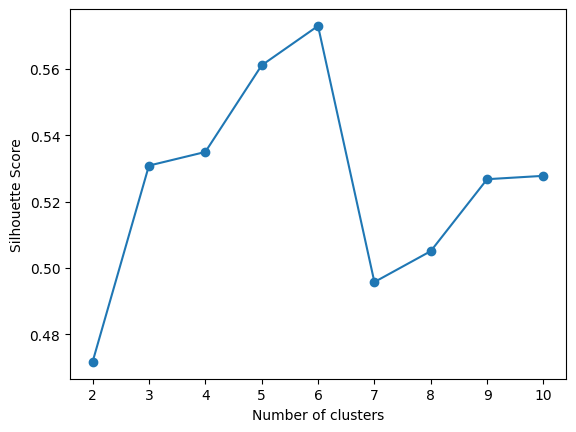

The best number of clusters is: 6


In [18]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


scaler = StandardScaler()
encoded_features_scaled = scaler.fit_transform(encoded_features)
# Dùng silhouette score để đánh giá chất lượng của việc phân cụm
silhouette_scores = []
possible_clusters = range(2, 11)  # Thử nghiệm từ 2 đến 10 cụm




for num_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(encoded_features_scaled)
    silhouette_scores.append(silhouette_score(encoded_features_scaled, cluster_labels))

# Vẽ biểu đồ silhouette score
plt.plot(possible_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tìm số lượng cụm tốt nhất (số cụm tương ứng với silhouette score lớn nhất)
best_num_clusters = possible_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"The best number of clusters is: {best_num_clusters}")


In [19]:
def kmeans_clustering(encoded_features, num_clusters):
    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    encoded_features_scaled = scaler.fit_transform(encoded_features)

    # Sử dụng K-means để phân cụm người dùng

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(encoded_features_scaled)

    return cluster_labels

In [20]:
num_clusters=5

In [21]:
cluster_labels = kmeans_clustering(encoded_features, num_clusters=num_clusters)
cluster_labels

array([3, 1, 1, ..., 1, 1, 1], dtype=int32)

In [22]:
cluster_labels.shape

(6471,)

In [23]:
train.loc[:, 'cluster_label'] = cluster_labels[train['UID']-1]

In [24]:
train

,UID,MID,rate,cluster_label
0,1187,4064,6,0
1,5866,4064,6,0
2,3033,4064,9,0
3,1406,4064,7,0
4,841,4064,8,0
...,...,...,...,...
38061,2190,135,6,0
38062,1530,135,9,0
38063,1308,135,7,0
38064,6009,135,6,0


Tạo ma trận item rating

In [25]:
num_item = len(train['MID'].unique())
item_ratings = np.zeros((num_clusters, num_item))
item_ratings.shape

(5, 4506)

In [26]:
new_index = np.arange(1, 4507)
def compute_item_ratings(num_cluster, train):
    # Compute item ratings based on cluster similarity
    num_item = len(train['MID'].unique())
    item_ratings = np.zeros((num_cluster, num_item))
    for i, cluster_label in enumerate(range(num_cluster)):
        cluster_members = train[train['cluster_label'] == cluster_label]

        cluster_ratings = cluster_members.groupby('MID')['rate'].mean()
        item_ratings[i, :] = cluster_ratings.reindex(new_index, fill_value=0).reset_index()['rate']

    return item_ratings

In [27]:
item_ratings_matrix = compute_item_ratings(num_cluster=num_clusters, train=train)
item_ratings_matrix[:, 3]

array([7.1, 0. , 0. , 0. , 0. ])

In [28]:
item_ratings_matrix.shape

(5, 4506)

Tạo ma trận user,những user thuộc cluster nào thì sẽ được đánh là 1

In [29]:
user_matrix = pd.DataFrame(cluster_labels, columns=['cluster_lable']).reset_index()
user_cluster_matrix = pd.get_dummies(user_matrix['cluster_lable']).astype(int).to_numpy()
user_cluster_matrix


array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [30]:
print(user_cluster_matrix.shape)

(6471, 5)


# Xử lý content-base (đã pretrain bên dưới)

> Train lại nếu chưa chạy trước, phía dưới có phần load model

In [ ]:
pip install transformers -q

Chạy thử 

In [ ]:
#from transformers import PhobertTokenizer, PhobertModel
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModel, AutoTokenizer, PhobertTokenizer
import torch
# Khởi tạo tokenizer và mô hình PhoBERT
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = PhobertTokenizer.from_pretrained("vinai/phobert-base")


# Ví dụ câu cần so sánh
sentence1 = "Câu số 1. câu số 2 "
sentence2 = "Câu số 2."

# Tokenize và chuyển đổi câu thành embeddings
tokens1 = tokenizer(sentence1, return_tensors="pt")
tokens2 = tokenizer(sentence2, return_tensors="pt")

with torch.no_grad():
    embeddings1 = phobert(**tokens1).last_hidden_state.mean(dim=1)
    embeddings2 = phobert(**tokens2).last_hidden_state.mean(dim=1)

# Tính cosine similarity giữa embeddings
similarity = cosine_similarity(embeddings1, embeddings2)
print(f"Cosine Similarity: {similarity[0][0]}")


#  Preprocessing

In [ ]:
train_by_user

In [ ]:
df_item = train_by_user.drop_duplicates(subset=['HotelID']).sort_values(by=['HotelID'])
df_item

In [ ]:
df_item = df_item[['HotelID', 'Descriptions']]

In [ ]:
df_item

In [ ]:
with open('/kaggle/input/stopword-vn/vietnamese.txt', 'r', encoding='utf-8') as file: 
    stopwordvn = file.readlines()
    list_stopword = list(set(w.strip() for w in stopwordvn))
    


In [ ]:
import re

In [ ]:
pip install underthesea -q

Thử nghiêm công cụ word segment

chạy thử

In [ ]:
>>> # -*- coding: utf-8 -*-
>>> from underthesea import word_tokenize
>>> sentence = 'Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'

>>> word_tokenize(sentence)
['Chàng trai', '9X', 'Quảng Trị', 'khởi nghiệp', 'từ', 'nấm', 'sò']

>>> word_tokenize(sentence, format="text")
'Chàng_trai 9X Quảng_Trị khởi_nghiệp từ nấm sò'

In [ ]:
#Xử lý lowecrcase, stopword 
def preprocessing_data(data):
    data = data.lower()
    #Xử lý dấu câu và ký tự đặc biệt
    data = re.sub(r"[^\w\s]", " ", data)
    #Loại bỏ stopword
    data = ' '.join([word for word in data.split() if word not in list_stopword])
    #Word segment
    data = word_tokenize(data, format='text')
    #Chuyển về wordembedding
    token = tokenizer(data, return_tensors='pt', max_length=256, truncation=True)
    with torch.no_grad():
        embedding = phobert(**token).last_hidden_state.mean(dim=1)
        
    return embedding

In [ ]:
from tqdm import tqdm

In [ ]:
len(df_item)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
embeddings = []
for i in tqdm(range(0, len(df_item))):
    embedding = preprocessing_data(df_item['Descriptions'].iloc[i])[0].numpy()
    embeddings.append(embedding)

In [ ]:
cosine_sim = linear_kernel(embeddings, embeddings)

In [ ]:
with open('cosine_sim_item_linear_kernel.pkl', 'wb') as file: 
    pickle.dump(cosine_sim, file)

# Load file Item-similarity lên (đã pretrain)

In [31]:
# Mở file trong chế độ đọc nhị phân
with open('/kaggle/input/item-similarity/cosine_sim_item_linear_kernel.pkl', 'rb') as file:
    # Sử dụng pickle.load để load dữ liệu từ file
    cosine_sim = pickle.load(file)

In [32]:
cosine_sim

array([[30.673069, 30.312088, 27.652016, ..., 29.261345, 20.42305 ,
        29.533005],
       [30.312088, 36.153458, 30.171526, ..., 31.38098 , 22.323763,
        32.031742],
       [27.652016, 30.171526, 31.846298, ..., 30.213017, 19.213648,
        30.717478],
       ...,
       [29.261345, 31.38098 , 30.213017, ..., 32.32114 , 20.271591,
        30.634575],
       [20.42305 , 22.323763, 19.213648, ..., 20.271591, 29.061543,
        20.106825],
       [29.533005, 32.031742, 30.717478, ..., 30.634575, 20.106825,
        33.94046 ]], dtype=float32)

In [33]:
cosine_sim.shape

(4506, 4506)

In [34]:

def get_top_similar_items(itemid, topk):
    sim_scores = list(enumerate(cosine_sim[itemid]))
    sim_item = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    list_sim_itemid = [item[0] for item in sim_item[1:topk]]
    return list_sim_itemid 

In [35]:
get_top_similar_items(1, 10)

[2532, 3069, 1972, 679, 349, 1628, 4363, 104, 1088]

# Cập nhật lại rating dự theo các item tương đồng trong 1 cụm

In [36]:
item_ratings_matrix[0][0]

8.125

In [37]:
item_ratings_matrix.shape

(5, 4506)

In [38]:
def update_rating(item_ratings_matrix, topk):
    for i in range(item_ratings_matrix.shape[0]): #tính theo từng cluster
        for item in range(item_ratings_matrix.shape[1]): #tính theo từng item
            if item_ratings_matrix[i][item] == 0: 
                top_sim_item = get_top_similar_items(item, topk)
                all_score_cluster = [item_ratings_matrix[i][j] for j in top_sim_item if item_ratings_matrix[i][j] !=0]
                avg_rating = sum(all_score_cluster)/(len(all_score_cluster)+1e-5)
                #cập nhật rating cho vị trí bằng 0
                item_ratings_matrix[i][item] = avg_rating
                
                
    return item_ratings_matrix

In [39]:
item_ratings_matrix

array([[8.125     , 7.125     , 8.22222222, ..., 7.        , 6.        ,
        9.75      ],
       [8.        , 6.5       , 0.        , ..., 0.        , 0.        ,
        9.        ],
       [0.        , 0.        , 0.        , ..., 9.        , 0.        ,
        6.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
update_rating_matrix = update_rating(item_ratings_matrix, topk=100)

In [41]:
update_rating_matrix

array([[8.125     , 7.125     , 8.22222222, ..., 7.        , 6.        ,
        9.75      ],
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ],
       [6.74999438, 6.37499469, 6.66666111, ..., 9.        , 7.69545892,
        6.        ],
       [6.74998313, 5.999985  , 7.4999625 , ..., 6.2718054 , 6.26810301,
        6.3184056 ],
       [0.        , 0.        , 0.        , ..., 8.99961731, 0.        ,
        8.9996181 ]])

In [42]:
update_rating_matrix.shape

(5, 4506)

In [43]:
user_cluster_matrix.shape

(6471, 5)

In [44]:
def user_item_matrix(user_cluster_matrix, update_rating_matrix):
    result_dot = np.dot(user_cluster_matrix, update_rating_matrix)
    return result_dot

In [45]:
user_rating_matrix = user_item_matrix(user_cluster_matrix, update_rating_matrix)
user_rating_matrix

array([[6.74998313, 5.999985  , 7.4999625 , ..., 6.2718054 , 6.26810301,
        6.3184056 ],
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ],
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ],
       ...,
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ],
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ],
       [8.        , 6.5       , 7.46405361, ..., 7.30642202, 7.6316086 ,
        9.        ]])

In [46]:
user_rating_matrix.shape

(6471, 4506)

# Evaluation

In [47]:
def get_list_4test(user_rating_matrix, test):
    test_list = []
    for i in range(test.shape[0]):
        rating = user_rating_matrix[test.iloc[i]['UID'] - 1][test.iloc[i]['MID'] - 1]
        test_list.append(rating)
    
    return test_list

In [48]:
test_list = get_list_4test(user_rating_matrix, test)
test_list[:10]

[7.285714285714286,
 8.333333333333334,
 8.333333333333334,
 7.5,
 7.166666666666667,
 7.285714285714286,
 6.333333333333333,
 7.583333333333333,
 7.583333333333333,
 6.0]

In [49]:
ground_truth = test['rate'].values
ground_truth[:10]

array([5, 6, 7, 8, 7, 6, 8, 6, 6, 7])

> MSE

In [50]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ground_truth , test_list)
print('MSE =',mse)

MSE = 2.4576047825315803


RMSE

In [51]:
import math
rmse = math.sqrt(mse)
print('RMSE =',rmse)     

RMSE = 1.567674960740134


MAE

In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(ground_truth , test_list)
print('MAE =',mae)

MAE = 1.3288965661790506


NMAE

In [53]:
MAX = max(test['rate'].tolist())
MIN = min(test['rate'].tolist())

nmae = mae/(MAX-MIN)
print('----- NMAE =',nmae)

----- NMAE = 0.22148276102984177


NDCG

In [54]:
from sklearn.metrics import ndcg_score
# Sắp xếp danh sách dự đoán và ground truth
sorted_idx = np.argsort(test_list)[::-1]  # Sắp xếp giảm dần
sorted_ground_truth = ground_truth[sorted_idx]

# Tính toán NDCG
ndcg = ndcg_score([ground_truth], [sorted_ground_truth])
print(f"NDCG: {ndcg}")

NDCG: 0.9555053489383882


# Lưu lại kết quả

In [ ]:
with open('best_ghrs.pkl', 'wb') as file:
    pickle.dump(user_rating_matrix, file)

In [ ]:
user_rating_matrix.shape